In [201]:
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
import os
import math

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [202]:
def log(x):
    if x <= 0:
        return -math.log(-(x - 1))
    else: 
        return math.log(x + 1)

def load_data(resave=False):
    """
    If data.hdf doesn't exist, creates it (from train_data.csv and test_data.csv),
    dropping from train & test 'Unnamed: 0' and transforming date to datetime
    If exists, just loads it
    
    resave (bool): whether to respawn data.hdf again
    """
    if not os.path.isfile('data/data.hdf') or resave:
        train = pd.read_csv('data/train_data.csv', low_memory=False).drop('Unnamed: 0', axis=1)
        test = pd.read_csv('data/test_data.csv', low_memory=False).drop('Unnamed: 0', axis=1)
        train['date'] = pd.to_datetime(train.date)
        test['date'] = pd.to_datetime(test.date)
        train['first_prch'] = train.first_prch.apply(lambda x: datetime.strptime(x, '%d.%m.%y %H:%M:%S'))
        test['first_prch'] = test.first_prch.apply(lambda x: datetime.strptime(x, '%d.%m.%y %H:%M:%S'))
        #Count returns
        train_neg = train[train['sum_b'] < 0]
        train_neg_count = train_neg[['id']].groupby('id').size().reset_index(name='return_num')
        train = train.merge(train_neg_count, left_on='id', right_on='id', how='outer')
        test_neg = test[test['sum_b'] < 0]
        test_neg_count = test_neg[['id']].groupby('id').size().reset_index(name='return_num')
        test = test.merge(test_neg_count, left_on='id', right_on='id', how='outer')
        #replace all first_prch with earliest first_prch
        train_first = train.groupby('id').first_prch.min().reset_index(name='first_prch')
        train = train.drop('first_prch', axis=1).merge(train_first, left_on='id', right_on='id', how='outer')
        test_first = test.groupby('id').first_prch.min().reset_index(name='first_prch')
        test = test.drop('first_prch', axis=1).merge(test_first, left_on='id', right_on='id', how='outer')
        #log
        train.sum_b.apply(log)
        test.sum_b.apply(log)
        
        train.to_hdf('data/data.hdf', 'train')
        test.to_hdf('data/data.hdf', 'test')
    return pd.read_hdf('data/data.hdf', 'train'), pd.read_hdf('data/data.hdf', 'test')

def calculate_target(train, offset=0):
    """
    Returns X_train without last 30 days and Series with index=ids, values=target
    Target is built only for users who were present in the X_train (w\o last 30 days)
    
    offset (int): month for target is chosen as train.month.max() - offset
    """
    target_month = train.date.dt.month.max() - offset
    X_train = train.loc[train.date.dt.month < target_month]
    
    users = train.loc[train.date.dt.month == target_month].id.unique()
    #or aggregate by sum_b, see if the same
    users = np.intersect1d(users, X_train.id.unique())
    
    target = pd.Series(np.zeros((X_train.id.nunique())), index=X_train.id.unique())
    target.loc[users] = 1
    return X_train, target


def train_test_split(X_train, y_train, train_size=0.75):
    if train_size < 1:
        train_size = int(X_train.id.nunique() * train_size)
    assert(X_train.id.nunique() == y_train.shape[0])
    split_id = X_train.id.unique()[train_size]
    split_index = np.where(X_train.id == split_id)[0].min()
    return X_train.iloc[:split_index, :], X_train.iloc[split_index:, :], y_train.iloc[:train_size], y_train.iloc[train_size:]

In [203]:
# load_data(resave=True)
X_train, y_train = calculate_target(train, offset=0)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train)

/home/sokolov_yas/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['time', 'id', 'code']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [212]:
target_df = pd.DataFrame(target).reset_index()
target_df = target_df.rename(index=str, columns={"index": "id", "0": "target"})

In [213]:
X_tr_mod = X_tr.merge(target_df, left_on='id', right_on='id', how='outer')

## distribution of values of all variables

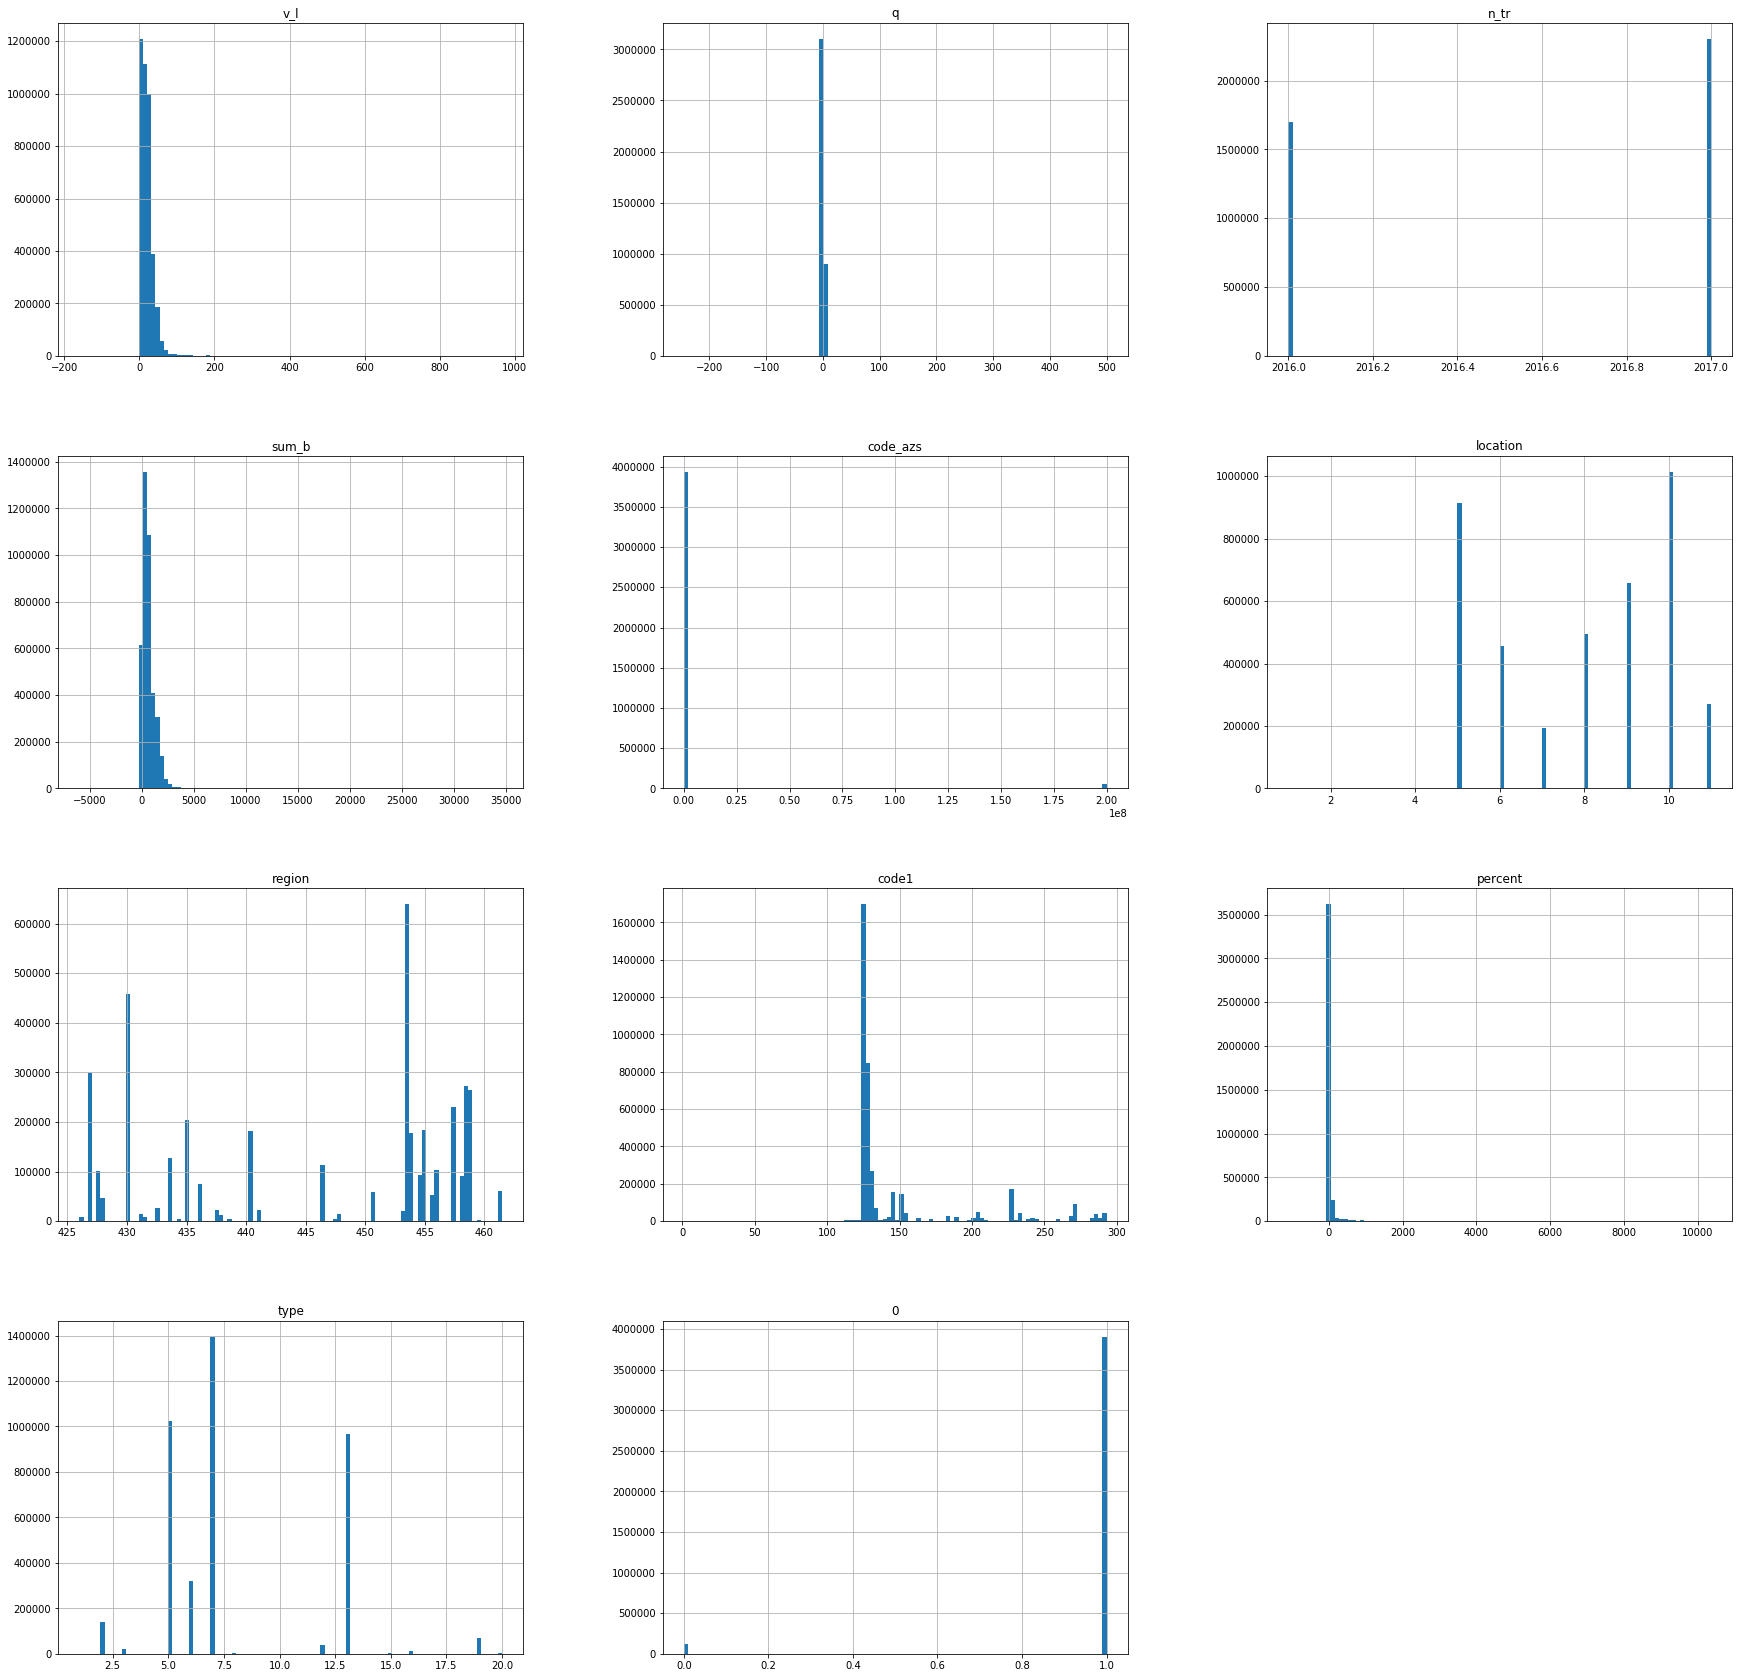

In [214]:
X_tr_mod.hist(bins=100, figsize=(30,30)); 

### Ideas for features
v_l, q and sum_b -- exponential distribution, need to be logarithmed

### Payment type
Many of the customers pay with 5, 7 and 13 types

### Location
The most popular locations are 5 and 10

## heatmap

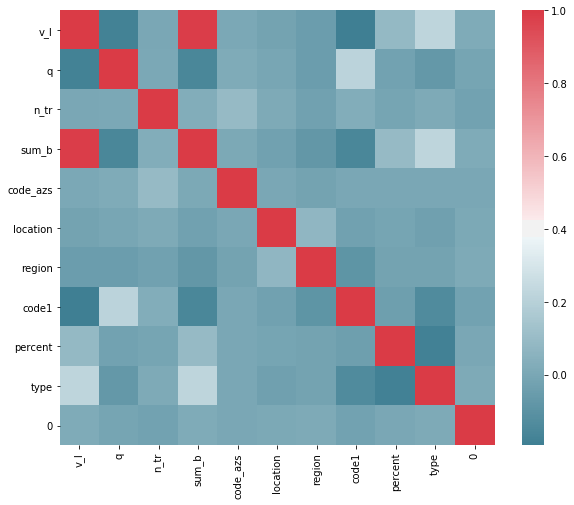

In [176]:
f, ax = plt.subplots(figsize=(10, 8))
corr = X_train_mod.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

negative correlations (the less the value of one variable is, the higher the value of the second variable is):

    code1 - v_l -> subcategory of the product and the amount of oil bought
    sum_b - q -> sum of purchase and amount of additional products bought
    type - percent -> type of payment and percent of discount 
    q - v_l -> amount of additional products bought and amount of oil bought
    
    
none of the features correlate with target

## num of unique values

In [177]:
X_train.nunique()

time           86391
date             669
v_l            15410
q                 78
n_tr               2
sum_b         234372
code_azs        1278
id             73055
first_prch     68500
location          11
region            39
code             151
code1            260
percent        65593
type              20
dtype: int64

## num of nulls for variables

In [184]:
X_train.isnull().sum()

time          1385981
date                0
v_l                 0
q                   0
n_tr                0
sum_b              76
code_azs         2888
id                  0
first_prch          0
location          419
region           2014
code                0
code1           26529
percent           278
type                0
dtype: int64

The highest amount of NaNs is in code_azs, region, code1

## unique values of categirical variables

Most popular locations are 10 and 5

In [216]:
pd.value_counts(X_train['location'].values, sort=True)


10.0    1241989
5.0     1164501
9.0      822682
8.0      624239
6.0      584533
11.0     340636
7.0      246159
3.0         624
1.0         520
2.0         484
4.0         386
dtype: int64

Most popular subcategories of products

In [217]:
pd.value_counts(X_train['code1'].values, sort=True)

126.0    2131571
128.0    1037226
132.0     331564
146.0     133742
152.0     131891
270.0     110740
226.0      86315
227.0      76655
145.0      60778
203.0      60619
134.0      57690
228.0      53504
293.0      50217
154.0      45922
287.0      36866
151.0      33766
269.0      33588
133.0      32440
233.0      31642
189.0      28432
183.0      26178
150.0      22598
284.0      21341
127.0      17831
234.0      17389
206.0      17308
142.0      14986
242.0      13921
288.0      13058
202.0      13005
          ...   
105.0          1
15.0           1
14.0           1
143.0          1
224.0          1
137.0          1
6.0            1
4.0            1
86.0           1
67.0           1
66.0           1
38.0           1
68.0           1
69.0           1
72.0           1
57.0           1
55.0           1
53.0           1
75.0           1
51.0           1
49.0           1
77.0           1
47.0           1
46.0           1
78.0           1
43.0           1
215.0          1
81.0          

Most popular categories of products -- a lot of garbage among the least popular categories

In [221]:
pd.value_counts(X_train['code'].values, sort=True)

01010121                                     1912675
01010131                                      930898
01010132                                      297446
1010121                                       218896
02110000                                      203527
02250000                                      184622
02240000                                      125720
01010211                                      120307
1010131                                       106328
01010213                                       98694
02210000                                       84956
02260000                                       79341
02300000                                       61108
02390000                                       40247
1010132                                        34118
02220000                                       30805
02070000                                       30167
01010221                                       29627
01010142                                      

## Distribution of purchase amount and date of purchase

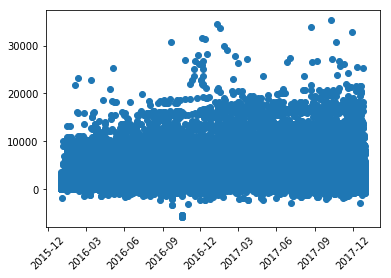

In [193]:
plt.xticks(rotation=45)
plt.plot_date(train['date'], train['sum_b']);

Peaks of purchase volume during winter season (december)

## Distribution of amount of bought oil and date of purchase

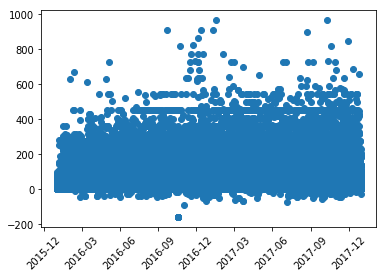

In [219]:
plt.xticks(rotation=45)
plt.plot_date(train['date'], train['v_l']);

Same thing as for the purchase amount -- peaks are during the winter season

## Distribution of negative purchases

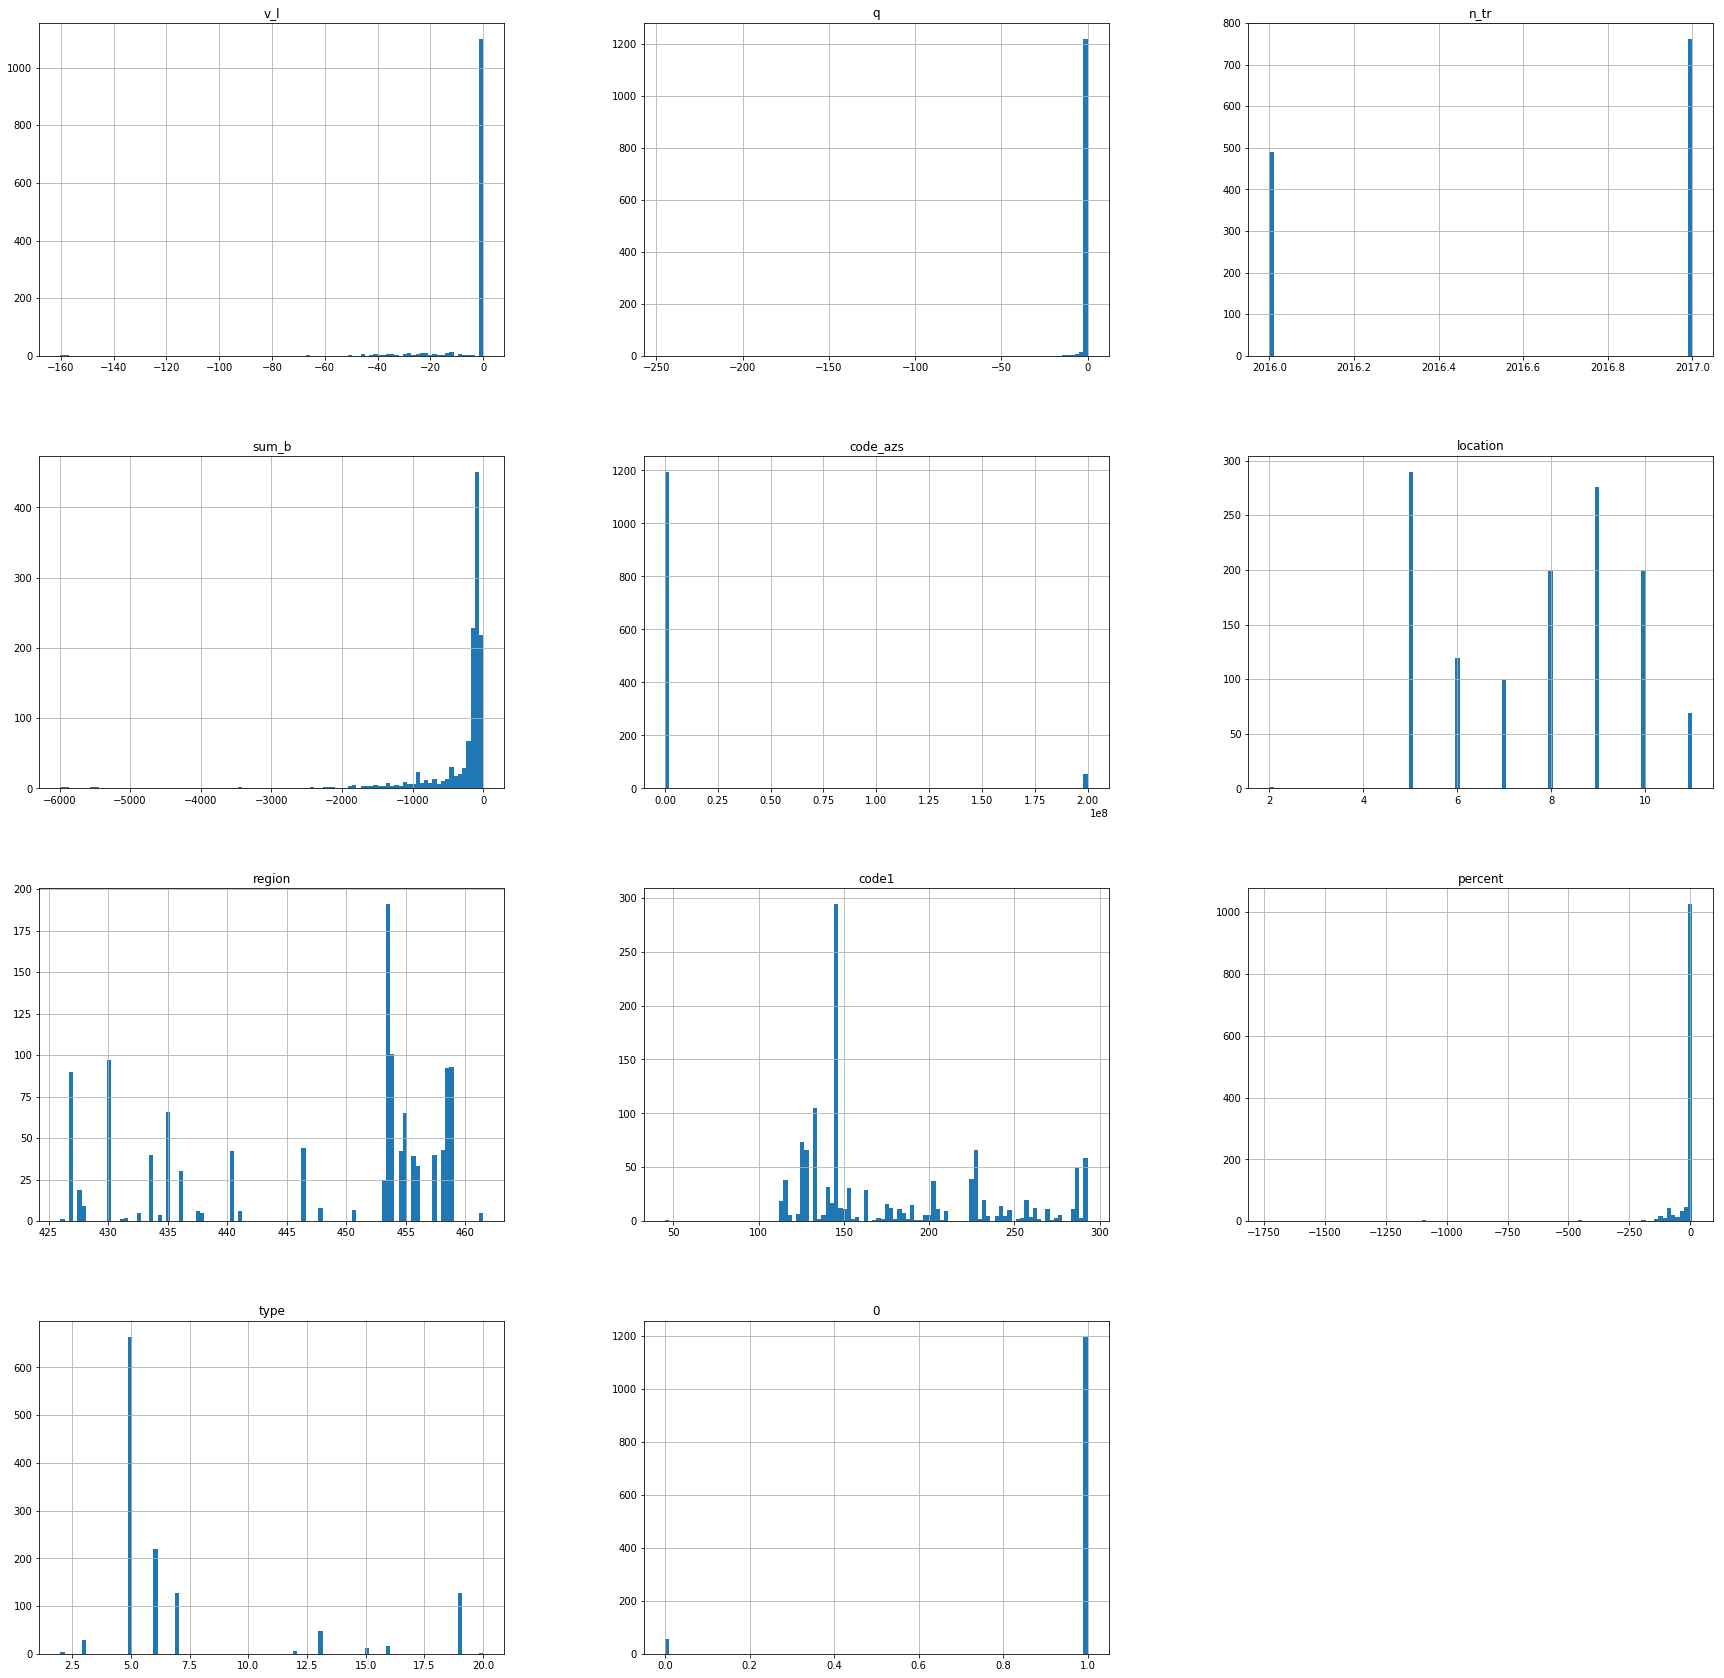

In [189]:
df_neg = X_train_mod[X_train_mod['sum_b'] < 0]
df_neg.hist(bins=100, figsize=(30,30));  

## Distribution of non-negative purchases

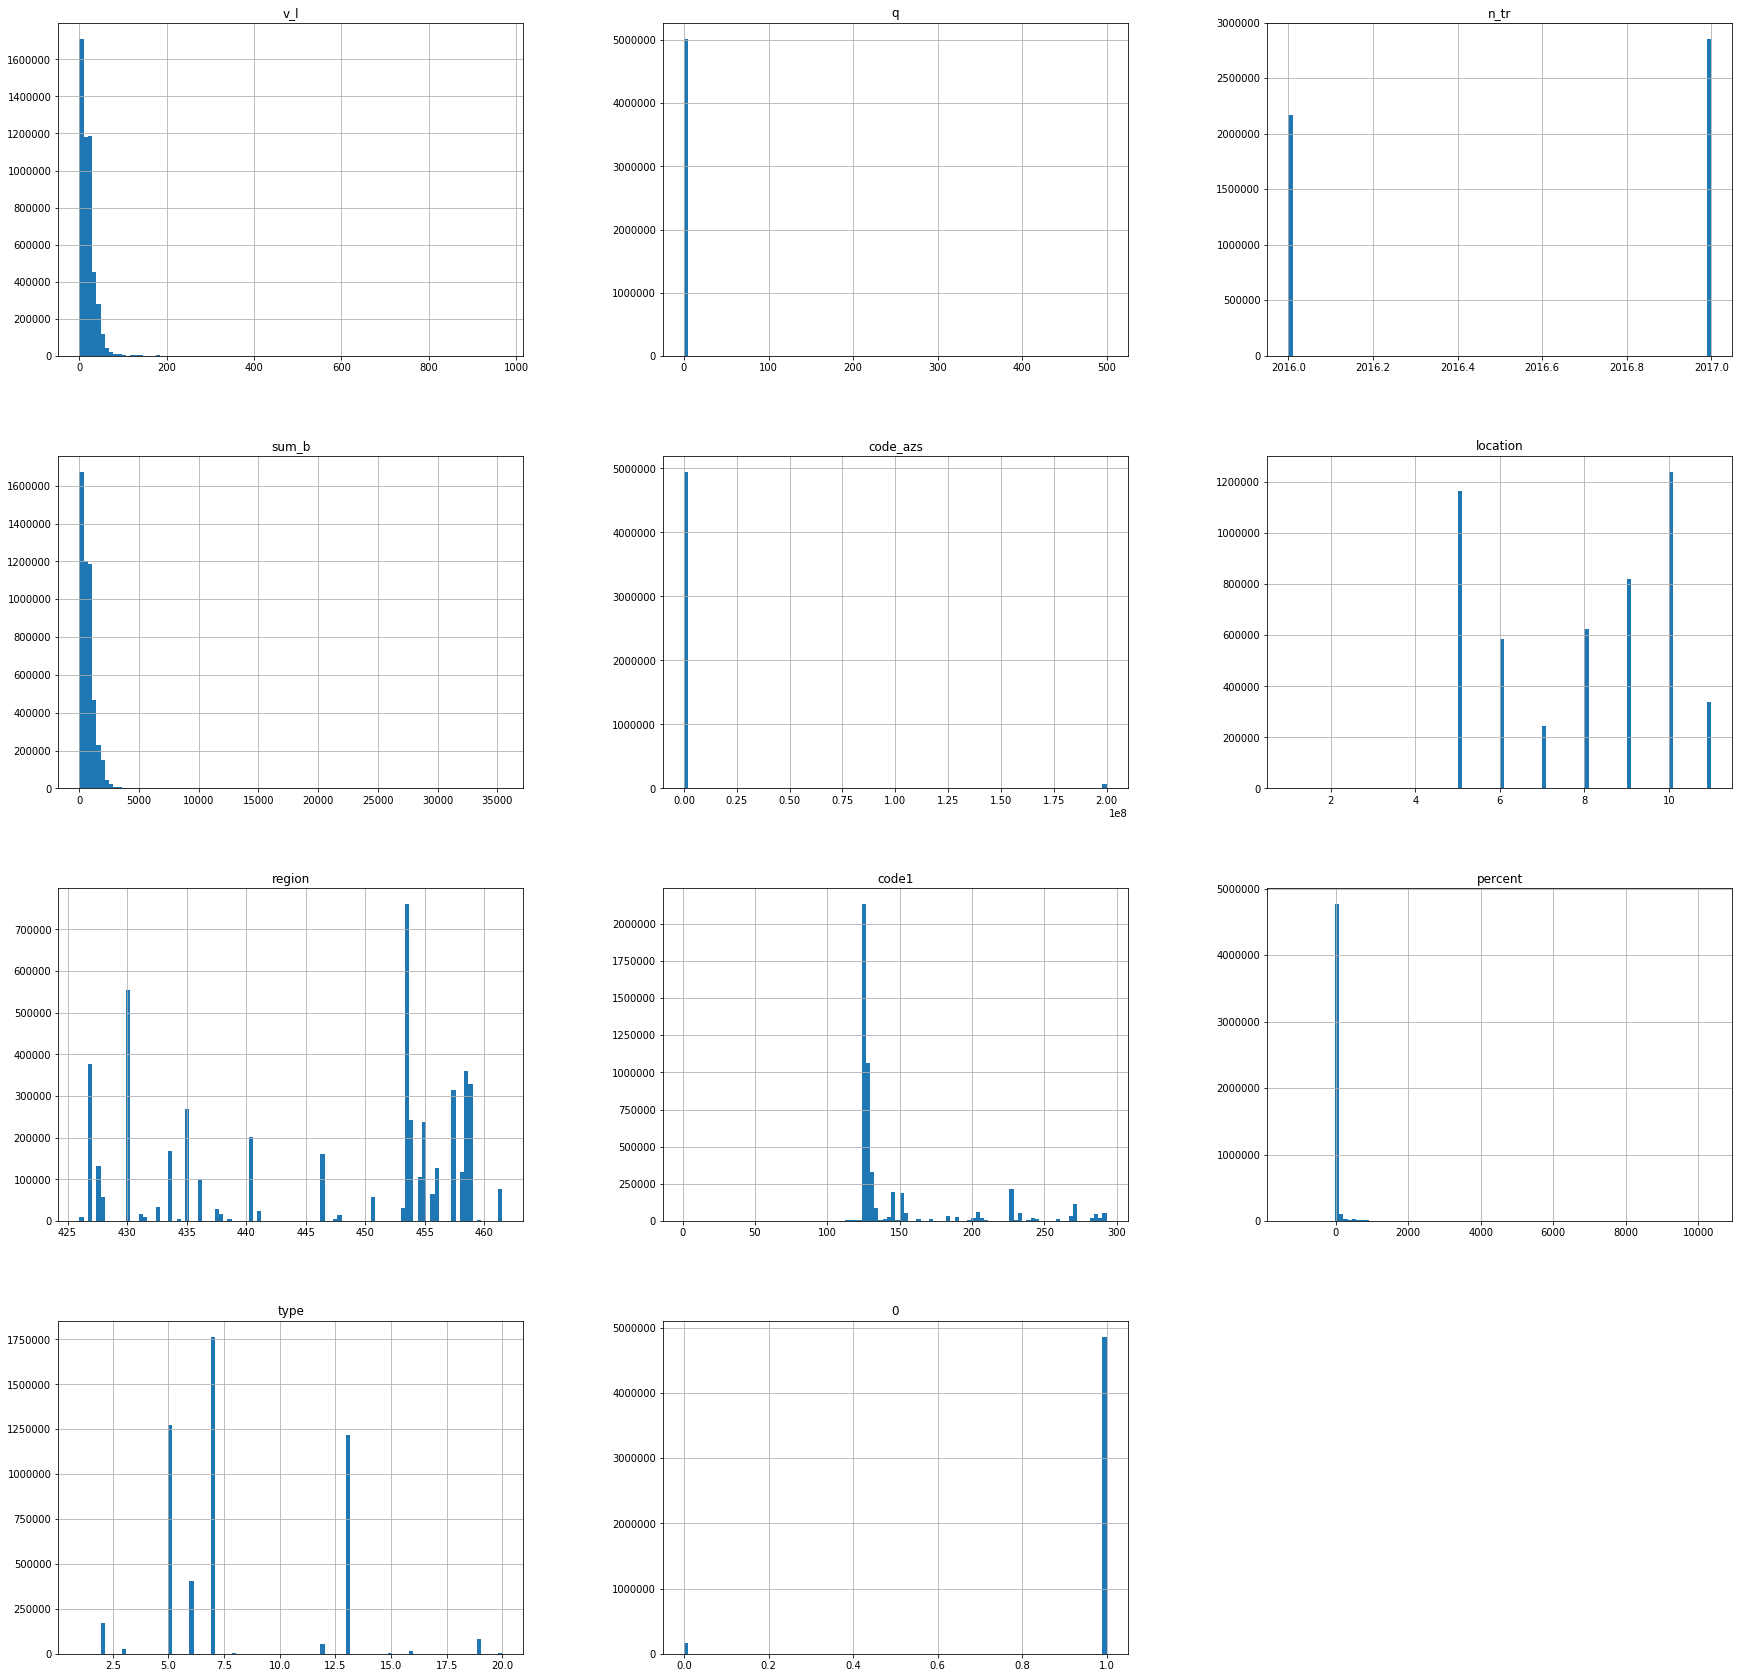

In [190]:
df_pos = X_train_mod[X_train_mod['sum_b'] > 0]
df_pos.hist(bins=100, figsize=(30,30));  

Variables that differ for negative and non-negative purchases: code1, location, type, target

It is evident that negative purchases mean return of product